In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re
import os
from PIL import Image
import requests
from io import BytesIO
from joblib import Parallel, delayed

from glob import glob
from tqdm import tqdm_notebook

from itertools import chain
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
# !pip install joblib

In [4]:
#newpath = 'external_data' 
#if not os.path.exists(newpath):
#    os.makedirs(newpath)


def get_html(url):
    response = requests.get(url)
    return response.text
#from https://www.proteinatlas.org/download/subcellular_location.tsv.zip
subcellular_location = pd.read_csv('../data/external_data/subcellular_location.tsv', sep="\t",index_col = None)


#get urls
urls = []
for name in subcellular_location[['Gene', 'Gene name']].values:  
    name = '-'.join(name)
    url = ('https://www.proteinatlas.org/'+name+'/antibody#ICC')
    urls.append(url)
    
def load_img(url):
    html = get_html(url)
    soup = BeautifulSoup(html, 'lxml')

    links = []
    for a in soup.findAll('a',{'class':'colorbox'},href=True):
        if '_selected' in  a['href']:
            links.append(''.join(('https://www.proteinatlas.org'+a['href']).split('_medium')))
    
    i = 0
    for link in set(links):
        try:
            name = url.split('/')[-2]        
            response = requests.get(link)
            img = Image.open(BytesIO(response.content))
            if np.array(img)[:,:,0].mean()<70:
                img.save('external_data/'+name+'_'+str(i)+'.png')
                i+=1
                #break
        except:
            pass


In [5]:
label_names = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
  }

all_label_names = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings",
    # new classes          
    28: "Vesicles",
    29: "Nucleus",
    30: "Midbody",
    31: "Cell Junctions",
    32: "Midbody ring",
    33: "Cleavage furrow"
         }

In [9]:
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [8]:
all_names = []
for j in tqdm_notebook(range(len(subcellular_location))):
    names = np.array(subcellular_location[['Enhanced','Supported','Approved','Uncertain']].values[j])
    names = [name for name in names if str(name) != 'nan']
    split_names = []
    for i in range(len(names)):
        split_names = split_names +(names[i].split(';'))

    all_names.append(split_names)
    
subcellular_location['names'] = all_names

HBox(children=(IntProgress(value=0, max=12073), HTML(value='')))

(800, 800)


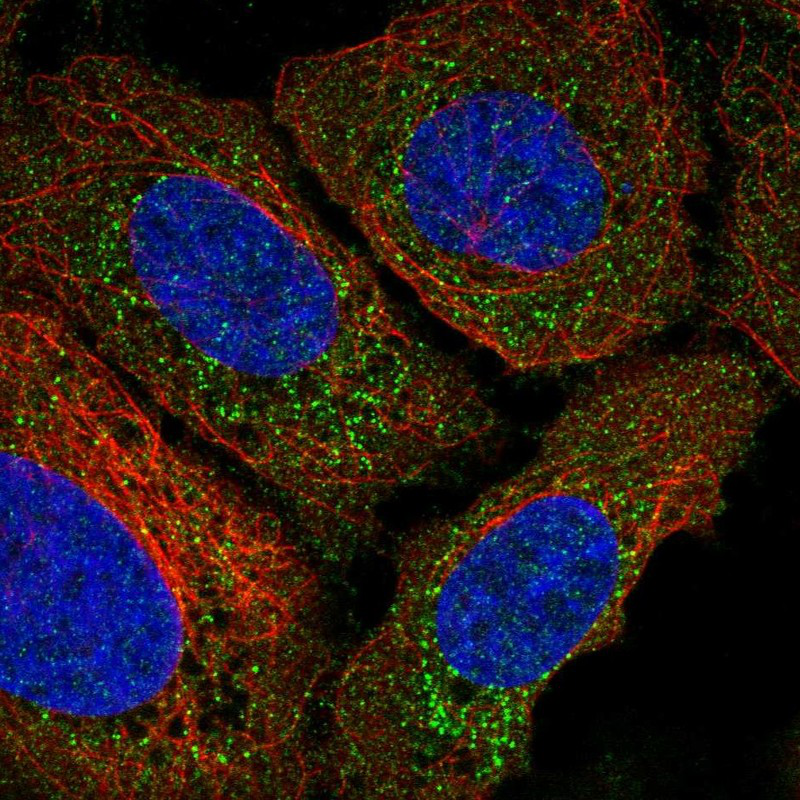

In [13]:
from PIL import Image

img = Image.open(glob('../data/external_data/external_data_1/*')[0])
print(img.size)
img

In [14]:
#only old names
data = []
for i in tqdm_notebook(range(len(subcellular_location))):
    im_name  = subcellular_location['Gene'].values[i]+'-'+subcellular_location['Gene name'].values[i]
    for im in glob('../data/external_data/external_data_1/'+im_name+'*'):
        labels = []
        for name in subcellular_location['names'].values[i]:
            try:
                if name == 'Rods & Rings': name = "Rods & rings"
                labels.append(list(label_names.values()).index(name))          
            except:
                pass
        if len(labels)>0:
            data.append([im.split('/')[-1].split('.png')[0], subcellular_location['names'].values[i], labels])

HBox(children=(IntProgress(value=0, max=12073), HTML(value='')))

In [15]:
df = pd.DataFrame(data, columns = ['id', 'names', 'labels'])
df.head()

,id,names,labels
0,ENSG00000000003-TSPAN6_0,[Cytosol],[25]
1,ENSG00000000457-SCYL3_0,"[Microtubules, Nuclear bodies]","[14, 5]"
2,ENSG00000000460-C1orf112_0,[Mitochondria],[23]
3,ENSG00000000938-FGR_0,"[Aggresome, Plasma membrane]","[24, 21]"
4,ENSG00000001084-GCLC_1,"[Cytosol, Nucleoli, Nucleus]","[25, 2]"


In [16]:
df.to_csv('../data/external_data.csv')

In [17]:
len(df)

12760